In [1183]:
import json
import torch.nn as nn
import matplotlib.pyplot as plt
from globals import *
from utilities import *

In [1184]:
with open("data/trump_data.json", "r") as file:
    trump_data = json.load(file)

with open("data/pepe_data.json", "r") as file:
    pepe_data = json.load(file)

with open("data/spx_data.json", "r") as file:
    spx_data = json.load(file)

with open("data/mstr_data.json", "r") as file:
    mstr_data = json.load(file)

with open("data/MARS_data.json", "r") as file:
    mars_data = json.load(file)

with open("data/NEIRO_data.json", "r") as file:
    neiro_data = json.load(file)

with open("data/HANA_data.json", "r") as file:
    hana_data = json.load(file)

with open("data/DOGGO_data.json", "r") as file:
    doggo_data = json.load(file)

with open("data/JOE_data.json", "r") as file:
    joe_data = json.load(file)

with open("data/FEFE_data.json", "r") as file:
    fefe_data = json.load(file)

with open("data/WOJAK_data.json", "r") as file:
    wojak_data = json.load(file)

with open("data/some_data.json", "r") as file:
    some_data = json.load(file)

# --------------------------------------------

with open("data/token1_data.json", "r") as file:
    data1 = json.load(file)

with open("data/token2_data.json", "r") as file:
    data2 = json.load(file)

with open("data/token3_data.json", "r") as file:
    data3 = json.load(file)

with open("data/token4_data.json", "r") as file:
    data4 = json.load(file)

with open("data/token5_data.json", "r") as file:
    data5 = json.load(file)

In [1226]:
X, Y, Xn, Yn = preprocess_data(data5, epsilon=0.0)

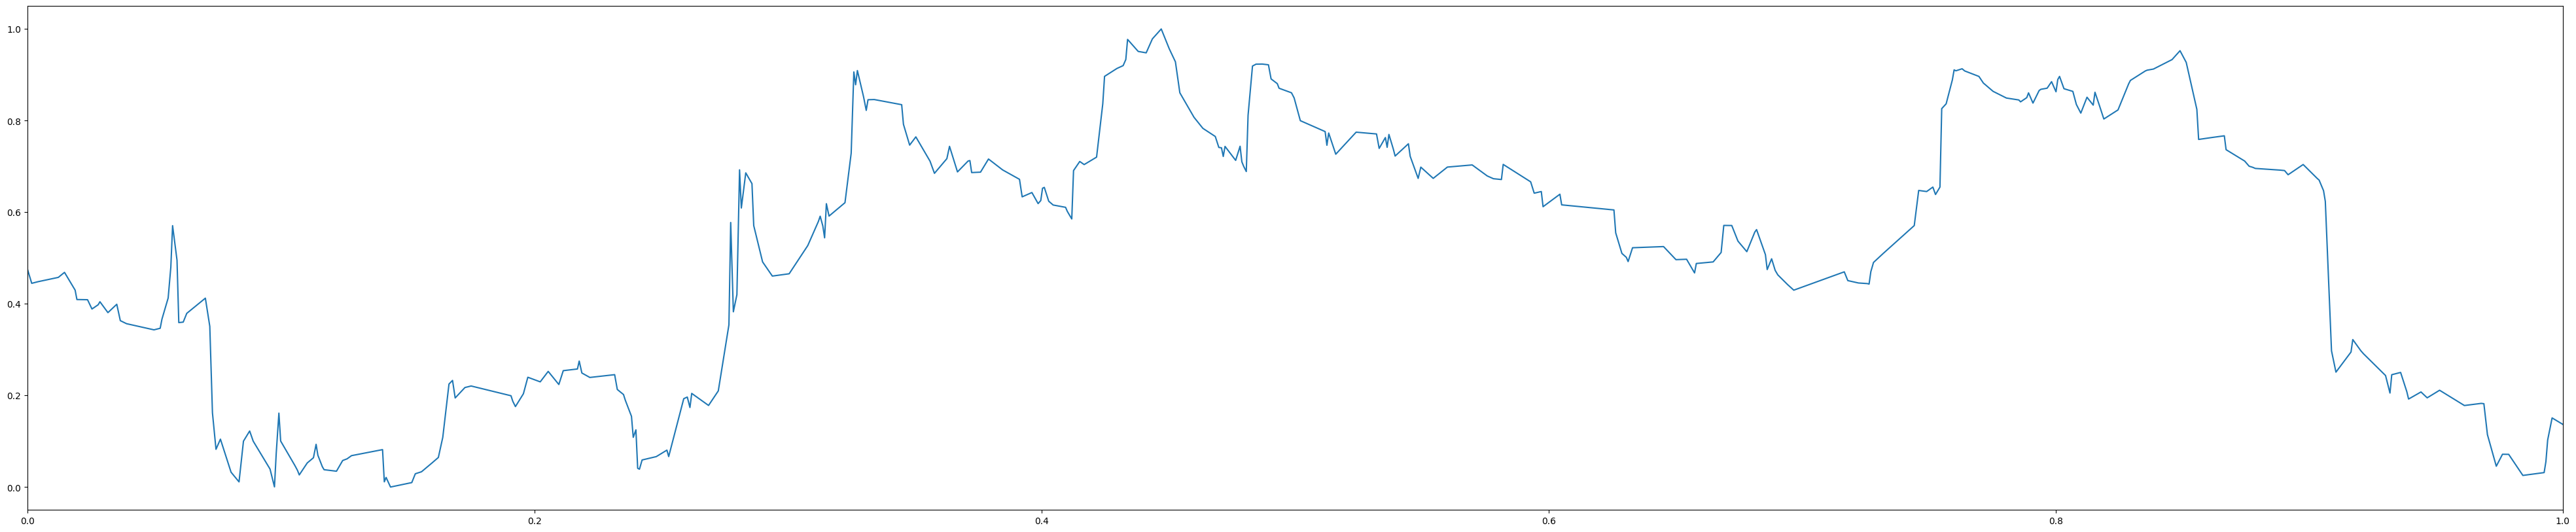

In [1227]:
# Approximated function
plt.figure(figsize=(50, 10))
plt.plot(Xn, Yn)
plt.margins(x=0);

In [1468]:
# preds - model forward, Y, extremums, mini, maxi
Xnplot = Xn.view(-1).numpy()
Ynplot = Yn.view(-1).numpy()

import plotly.graph_objects as go
from datetime import datetime

def timestamps_to_dates(timestamps: torch.tensor):
    """
    Convert a tensor of timestamps to a tensor of date strings.
    """
    format = "%d-%m-%Y %H:%M:%S"
    date_strings = [datetime.fromtimestamp(ts.item()).strftime(format) for ts in timestamps]
    return date_strings

dates = timestamps_to_dates(X.view(-1))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Xnplot, 
    y=Ynplot, 
    mode='lines', 
    name='Price', 
    line=dict(width=1, color='#1f77b4'),
    text=dates, 
    customdata=Y.view(-1).numpy(),
    hovertemplate="%{text}<br>%{customdata:.14f}$<extra></extra>"
    ))

fig.add_trace(go.Scatter(
    x=Xnplot, 
    y=preds.detach().view(-1).numpy(), 
    mode='lines', 
    name='Approximation',
    line=dict(width=2, color='#ff7f0e'),
    hoverinfo='none'
    ))

for i in extremums:
    x_value = Xnplot[i]
    fig.add_shape(
        type='line',
        x0=x_value, x1=x_value,
        y0=min(Ynplot), y1=max(Ynplot),
        line=dict(color='#2ca02c', width=2, dash="dash"),
        name="Exteremum",
        showlegend=(True if i == 0 else False)
    )

fig.add_shape(
    type='rect',
    x0=Xnplot[mini.item()],
    x1=Xnplot[maxi.item()],
    y0=min(Ynplot),
    y1=max(Ynplot),
    fillcolor='#d62728',
    opacity=0.25,
    line_width=0,
    showlegend=True,
    name="Fall Region"
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    template='simple_white',
    legend=dict(
        x=0.02,
        y=0.98,
        xanchor="left",
        yanchor="top",
    ),
    xaxis=dict(
        showline=False,
        zeroline=False, 
        showticklabels=False
    ),
    yaxis=dict(
        showgrid=True, 
        gridcolor="rgba(211, 211, 211, 0.4)",
        gridwidth=0.05, 
        showline=False,
        zeroline=False,
        showticklabels=False
    )
)

In [1228]:
input_size = 2
hidden_neurons = [8, 16, 16, 16, 8]

model = MLP(input_size, hidden_neurons, nn.LeakyReLU)
Xp = polynomial_features(Xn, input_size)

train_mlp(model, Xp, Yn, verbosity=True)
find_max_negative_slope(model, Xn, Y).item()

preds = model(Xp)

3513 iterations, 0.004999559372663498 loss


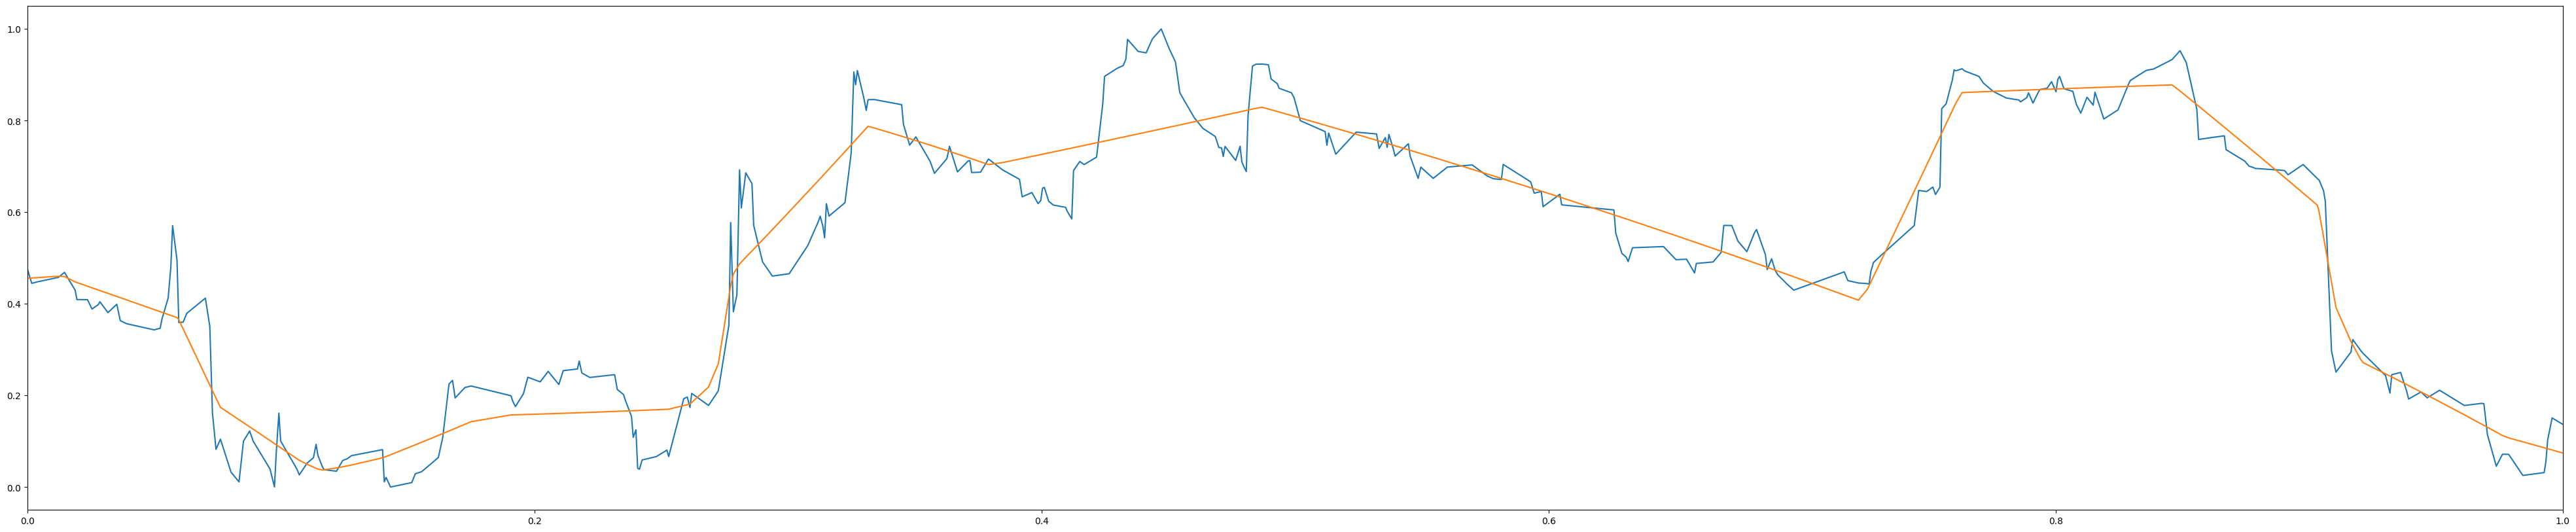

In [1229]:
# Approximated function
plt.figure(figsize=(50, 10))
plt.plot(Xn, Yn)
# Approximation
plt.plot(Xn, preds.detach())
plt.margins(x=0);

In [1230]:
grads = get_original_feature_gradients(model, Xn)

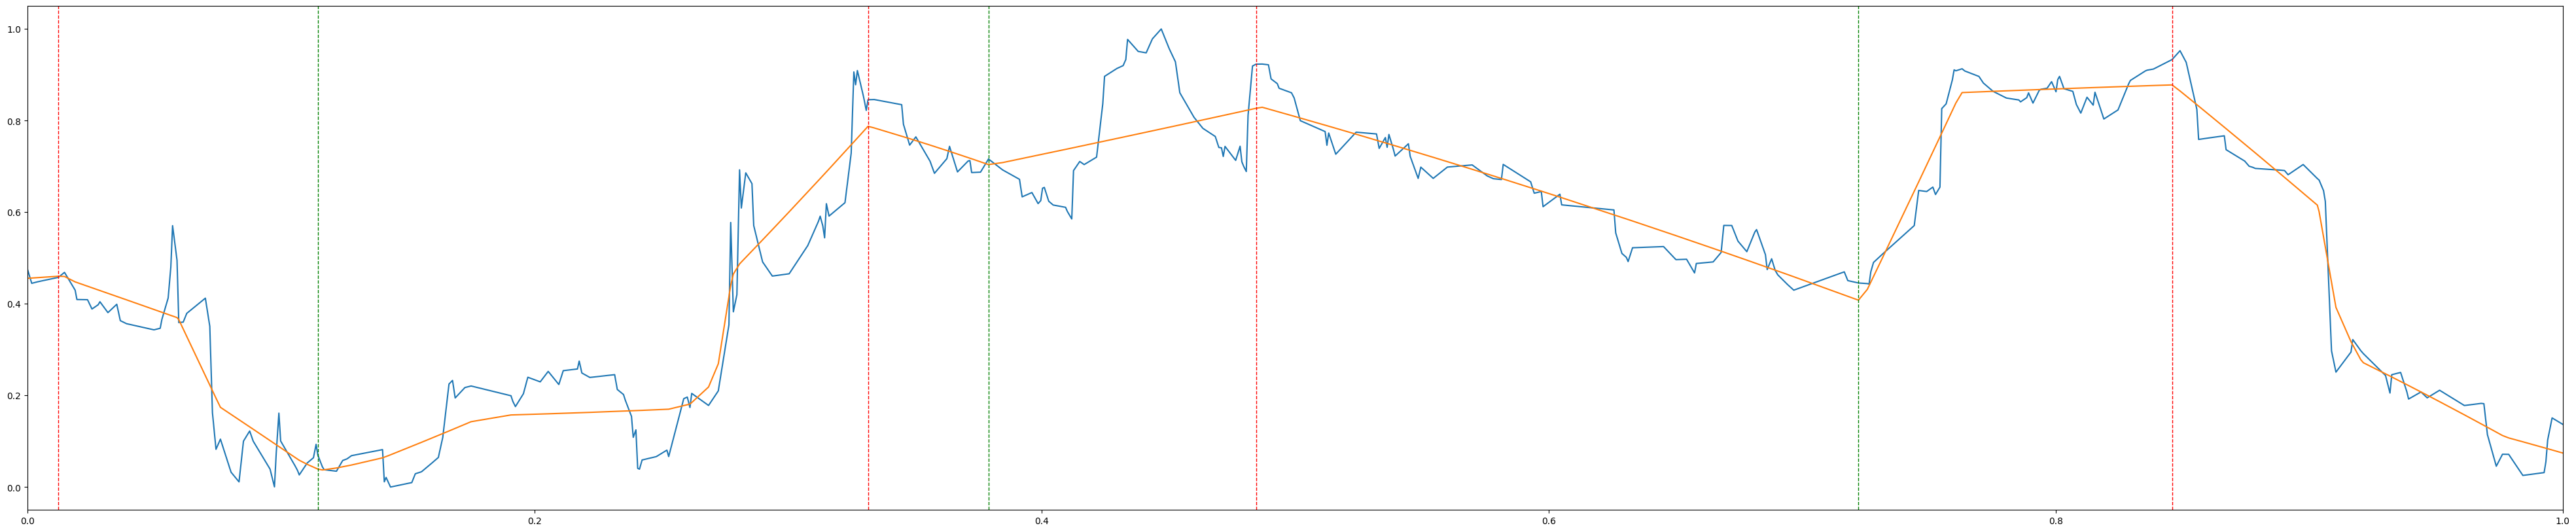

In [1231]:
fig, ax = plt.subplots(figsize=(50, 10))

ax.plot(Xn, Yn)
ax.plot(Xn, preds.detach())

extremums = [0]
for i, (prev, next) in enumerate(zip(grads, grads[1:])):
    if prev <= 0 and next > 0:
        ax.axvline(x=Xn[i], color='green', linestyle='--', linewidth=1)
        extremums.append(i)
    elif prev > 0 and next <= 0:
        ax.axvline(x=Xn[i], color='red', linestyle='--', linewidth=1)
        extremums.append(i)
extremums.append(349)

ax.margins(x=0);

In [1320]:
extremums

tensor([  0,   3,  46, 126, 141, 186, 252, 302, 349])

In [1330]:
for i, (prev, next) in enumerate(zip(extremums, extremums[1:])):
    print(f"{i}: {(Y[next] / Y[prev] - 1).item():+.17f} %")  # AFTER_DEBUG: devision by zero can occur here! 

0: -0.00438857078552246 %
1: -0.08997106552124023 %
2: +0.19762909412384033 %
3: -0.02752155065536499 %
4: +0.04527807235717773 %
5: -0.09992319345474243 %
6: +0.11333191394805908 %
7: -0.16619503498077393 %


In [1331]:
max_idx = grads.shape[0] - 1  # max index in gradients array

sign_changes = torch.where(grads[:-1] * grads[1:] <= 0)[0]  # after these indexes sign changes in gradients tensor
extremums = torch.cat([torch.tensor([0]), sign_changes, torch.tensor([max_idx])])  # and graph boundaries

ratios = Y[extremums[1:]] / Y[extremums[:-1]] - 1  # get fall ratios on each interval
max_fall_idx = ratios.argmin()  # get the steepest fall index
s, e = extremums[max_fall_idx], extremums[max_fall_idx + 1]  # restore interval edges

buff_size = 10
s = torch.clamp(s - buff_size, min=0)  # shift start pointer
e = torch.clamp(e + buff_size, max=max_idx + 1)  # shift left pointer
print(s, e)

min_val, max_val = torch.aminmax(Y[s:e])
res = min_val / max_val - 1.0
print(res.item())

tensor(292) tensor(350)
-0.19275951385498047


tensor(344) tensor(303)


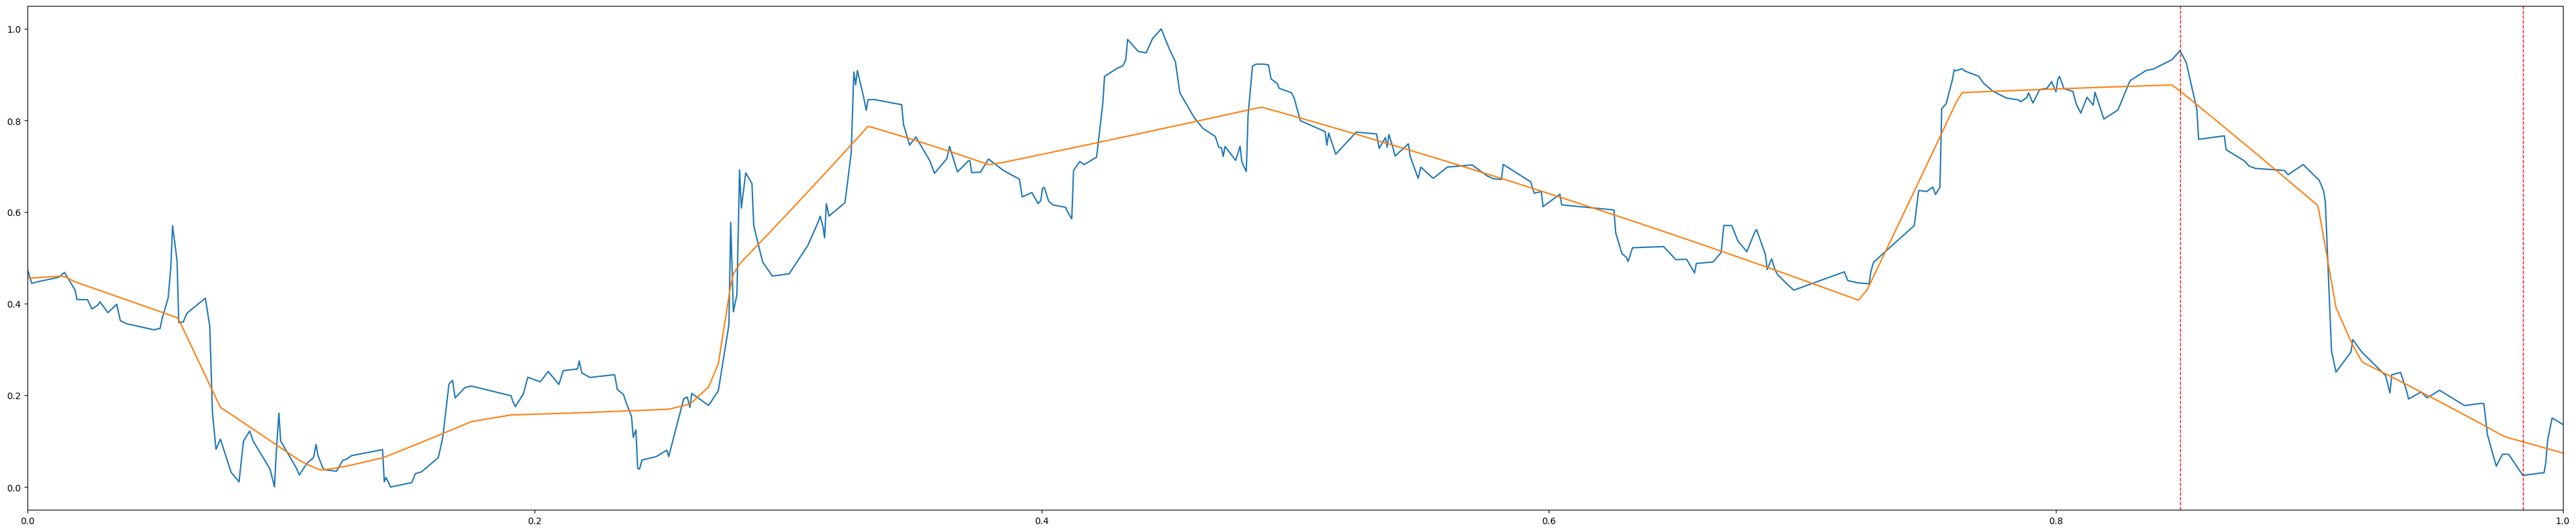

In [1332]:
fig, ax = plt.subplots(figsize=(50, 10))

ax.plot(Xn, Yn)
ax.plot(Xn, preds.detach())

mini = s + torch.argmin(Y[s:e])
maxi = s + torch.argmax(Y[s:e])

ax.axvline(x=Xn[mini], color='red', linestyle='--', linewidth=1)
ax.axvline(x=Xn[maxi], color='red', linestyle='--', linewidth=1)

print(mini, maxi)
ax.margins(x=0);